**Content based filtering**

# importlibrary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.dummy import DummyRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dot, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
import zipfile
import warnings
import itertools
from google.colab import drive
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import math
from collections import defaultdict

warnings.filterwarnings('ignore')
pd.set_option('mode.chained_assignment', None)

print("="*80)
print("SISTEM REKOMENDASI FILM - HYBRID APPROACH")
print("Content-Based + Collaborative Filtering")
print("="*80)

SISTEM REKOMENDASI FILM - HYBRID APPROACH
Content-Based + Collaborative Filtering


Penjelasan:

NumPy & Pandas: Untuk manipulasi data numerik dan dataframe
Matplotlib & Seaborn: Untuk visualisasi data
Scikit-learn: Untuk preprocessing, evaluasi model, dan algoritma machine learning
TensorFlow/Keras: Untuk membangun neural network
Scipy: Untuk operasi sparse matrix yang efisien

#load datset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Extract dataset
zip_path = '/content/drive/MyDrive/Content based filtering/archive (4).zip'
extract_path = '/content/content_based_filtering'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted successfully!")

# Define file paths
csv_path = '/content/content_based_filtering/content_movie_list.csv'
pickle_path = '/content/content_based_filtering/content_user_to_genre.pickle'
header_path = '/content/content_based_filtering/content_user_train_header.txt'

# Load data files
movie_list = pd.read_csv(csv_path)

# Load user header
with open(header_path, 'r') as header:
    for line in header:
        user_header = line.strip().split(',')

# Load user-genre preferences
with open(pickle_path, 'rb') as f:
    user_to_genre = pickle.load(f)

print("Data loaded successfully!")
print(f"Number of movies: {len(movie_list)}")
print(f"Number of users: {len(user_to_genre)}")

Mounted at /content/drive
Dataset extracted successfully!
Data loaded successfully!
Number of movies: 694
Number of users: 395


Yang dilakukan:

Mount Google Drive untuk akses file
Extract file ZIP berisi dataset
Load 3 file utama:

movie_list: Data film (694 film)
user_to_genre: Preferensi genre user (395 user)
user_header: Header kolom untuk data user



Hasil: Dataset berhasil dimuat dengan 694 film dan 395 user.

# DATA UNDERSTANDING & EDA

In [45]:
print("\n" + "="*60)
print("COMPREHENSIVE DATA UNDERSTANDING & ANALYSIS")
print("="*60)

# Basic movie data exploration
print("\n=== MOVIE DATA OVERVIEW ===")
print(f"Movie data shape: {movie_list.shape}")
print(f"Movie columns: {movie_list.columns.tolist()}")
print("\nSample movie data:")
print(movie_list.head())

print("\n=== USER DATA OVERVIEW ===")
print(f"Number of users: {len(user_to_genre)}")
print("\nSample user data structure (first user):")
# Print a sample entry from the defaultdict to show its structure
if user_to_genre:
    first_user_id = list(user_to_genre.keys())[0]
    print(f"User ID: {first_user_id}")
    print(user_to_genre[first_user_id])



COMPREHENSIVE DATA UNDERSTANDING & ANALYSIS

=== MOVIE DATA OVERVIEW ===
Movie data shape: (694, 6)
Movie columns: ['movieId', 'title', 'genres', 'rating_variance', 'unique_users', 'avg_rating']

Sample movie data:
   movieId                                 title                  genres  \
0     4054            Save the Last Dance (2001)           Drama|Romance   
1     4069           Wedding Planner, The (2001)          Comedy|Romance   
2     4148                       Hannibal (2001)         Horror|Thriller   
3     4149  Saving Silverman (Evil Woman) (2001)          Comedy|Romance   
4     4153                  Down to Earth (2001)  Comedy|Fantasy|Romance   

   rating_variance  unique_users  avg_rating  
0         1.147461            16    2.843750  
1         0.946281            22    2.909091  
2         1.271532            39    2.935897  
3         0.334711            11    2.772727  
4         0.909722            12    2.416667  

=== USER DATA OVERVIEW ===
Number of users: 

In [4]:
# Genre analysis
print("\n=== GENRE ANALYSIS ===")
all_genres = set()
genre_counts = defaultdict(int)

for genres in movie_list['genres']:
    genre_list = genres.split('|')
    all_genres.update(genre_list)
    for genre in genre_list:
        genre_counts[genre] += 1

print(f"Total unique genres: {len(all_genres)}")
print(f"All genres: {sorted(all_genres)}")


=== GENRE ANALYSIS ===
Total unique genres: 14
All genres: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']


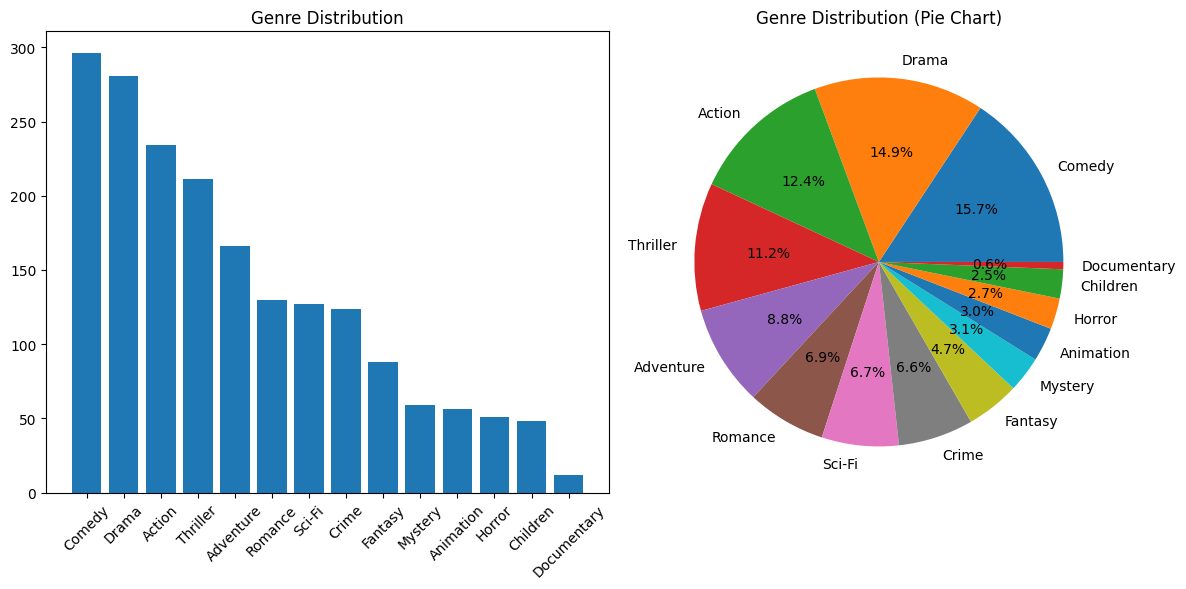

In [5]:
# Visualize genre distribution
plt.figure(figsize=(12, 6))
genres_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count'])
genres_df = genres_df.sort_values('Count', ascending=False)

plt.subplot(1, 2, 1)
plt.bar(genres_df['Genre'], genres_df['Count'])
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.pie(genres_df['Count'], labels=genres_df['Genre'], autopct='%1.1f%%')
plt.title('Genre Distribution (Pie Chart)')
plt.tight_layout()
plt.show()


In [6]:
# User data analysis
print("\n=== USER DATA ANALYSIS ===")
print(f"User header structure: {user_header}")
print(f"Total users: {len(user_to_genre)}")

# Analyze user rating patterns
user_stats = []
for user_id, user_data in user_to_genre.items():
    user_stats.append({
        'user_id': user_id,
        'rating_count': user_data['rating_count'],
        'rating_avg': user_data['rating_ave'],
        'num_movies': len(user_data['movies'])
    })
user_stats_df = pd.DataFrame(user_stats)



=== USER DATA ANALYSIS ===
User header structure: ['user id', 'rating count', 'rating ave', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
Total users: 395


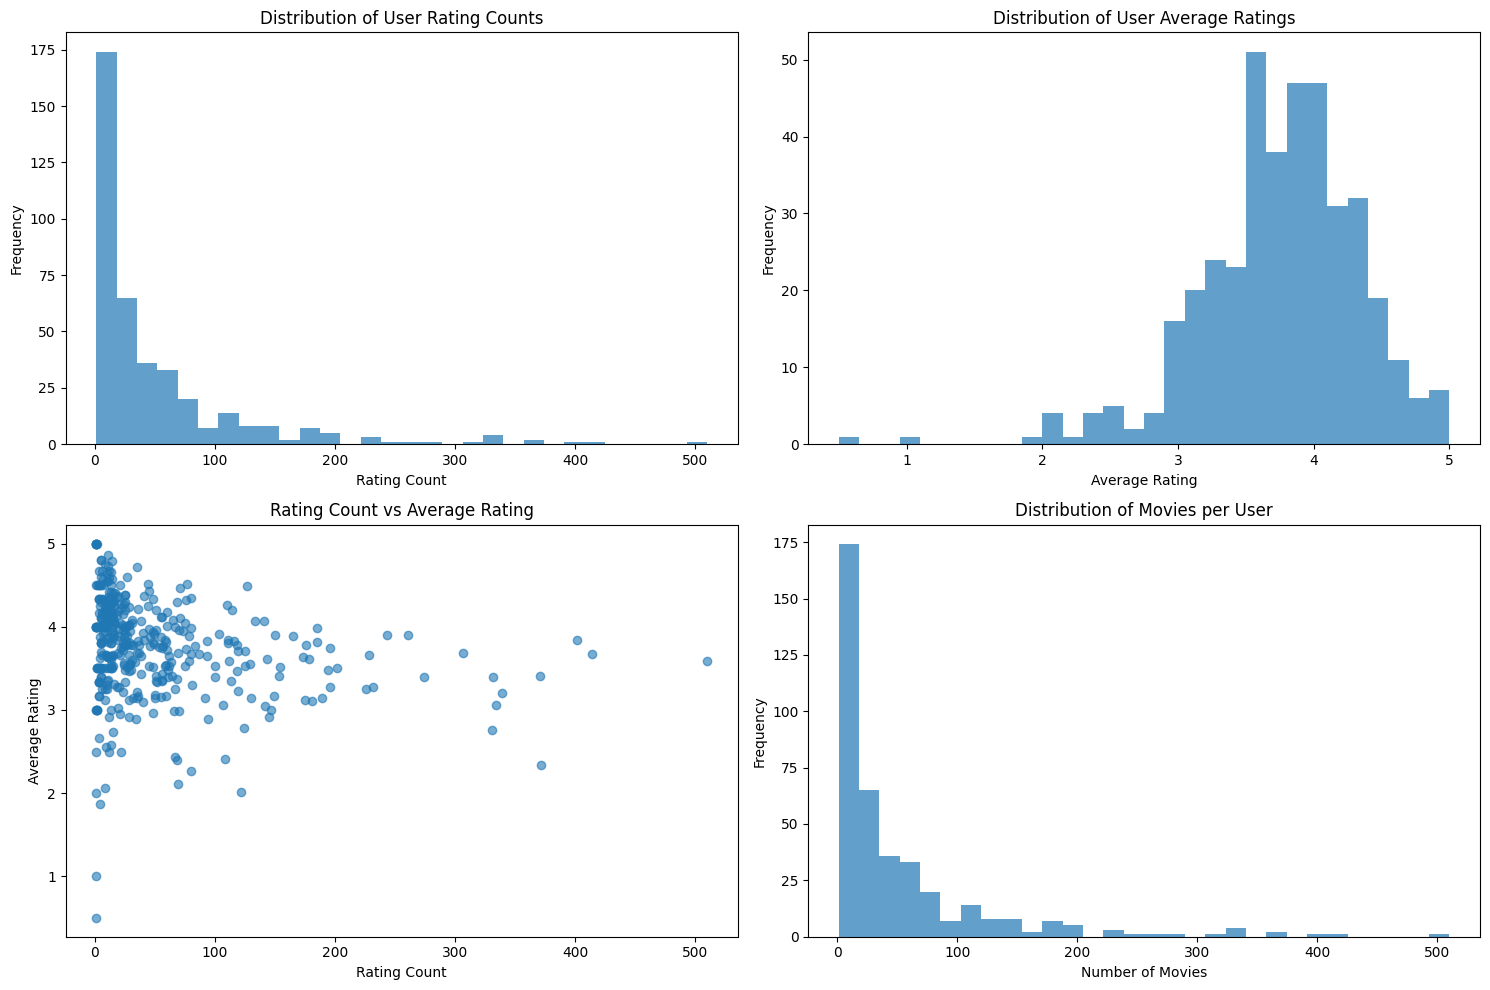

User statistics summary:
          user_id  rating_count  rating_avg  num_movies
count  395.000000    395.000000  395.000000  395.000000
mean   309.346835     51.144304    3.747147   51.144304
std    174.181315     73.048151    0.591190   73.048151
min      2.000000      1.000000    0.500000    1.000000
25%    160.500000      9.000000    3.435855    9.000000
50%    313.000000     23.000000    3.800000   23.000000
75%    460.500000     61.500000    4.117127   61.500000
max    610.000000    510.000000    5.000000  510.000000


In [7]:
# User statistics visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(user_stats_df['rating_count'], bins=30, alpha=0.7)
axes[0, 0].set_title('Distribution of User Rating Counts')
axes[0, 0].set_xlabel('Rating Count')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(user_stats_df['rating_avg'], bins=30, alpha=0.7)
axes[0, 1].set_title('Distribution of User Average Ratings')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].scatter(user_stats_df['rating_count'], user_stats_df['rating_avg'], alpha=0.6)
axes[1, 0].set_title('Rating Count vs Average Rating')
axes[1, 0].set_xlabel('Rating Count')
axes[1, 0].set_ylabel('Average Rating')

axes[1, 1].hist(user_stats_df['num_movies'], bins=30, alpha=0.7)
axes[1, 1].set_title('Distribution of Movies per User')
axes[1, 1].set_xlabel('Number of Movies')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"User statistics summary:")
print(user_stats_df.describe())


- Data Understanding & EDA
a. Eksplorasi Data Dasar
Menampilkan informasi dasar tentang data film (shape, kolom, sample data)

Menampilkan struktur data user (contoh entry pertama)

b. Analisis Genre
Mengidentifikasi 14 genre unik dari data film:
['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']

c. Visualisasi Distribusi Genre
Menampilkan dua visualisasi:

Bar Chart: Distribusi jumlah film per genre

Pie Chart: Persentase film per genre

Hasil visual menunjukkan bahwa genre Drama dan Comedy mendominasi dataset film, sementara genre seperti Documentary dan Fantasy memiliki representasi yang lebih kecil.

-  Data Understanding & Analysis
a. Overview Data Film
Shape: (694, 6) - 694 film dengan 6 atribut

Kolom: ['movieId', 'title', 'genres', 'rating_variance', 'unique_users', 'avg_rating']

Contoh data film menunjukkan informasi seperti judul, genre, variasi rating, jumlah user unik, dan rating rata-rata

b. Overview Data User
Jumlah user: 395

Struktur data user mencakup preferensi genre, jumlah rating, total rating, daftar film yang dirating, dan rating rata-rata

#ADVANCED DATA PREPARATION

In [8]:
print("\n" + "="*60)
print("ADVANCED DATA PREPARATION")
print("="*60)


ADVANCED DATA PREPARATION


#Calculate

In [9]:
# Calculate comprehensive movie statistics
print("\n=== CALCULATING MOVIE STATISTICS ===")
movie_list['total_rating_sum'] = 0
movie_list['total_rating_count'] = 0
movie_list['rating_variance'] = 0
movie_list['unique_users'] = 0

movie_ratings = defaultdict(list)


=== CALCULATING MOVIE STATISTICS ===


In [10]:
# Calculate detailed movie statistics
for user_id in user_to_genre:
    user_movies = user_to_genre[user_id]['movies']
    for movie_id, rating in user_movies.items():
        movie_ratings[movie_id].append(rating)

        # Update movie statistics
        mask = movie_list['movieId'] == movie_id
        movie_list.loc[mask, 'total_rating_sum'] += rating
        movie_list.loc[mask, 'total_rating_count'] += 1

In [11]:
# Calculate averages and variances
for idx, row in movie_list.iterrows():
    movie_id = row['movieId']
    if movie_id in movie_ratings:
        ratings = movie_ratings[movie_id]
        movie_list.loc[idx, 'avg_rating'] = np.mean(ratings)
        movie_list.loc[idx, 'rating_variance'] = np.var(ratings)
        movie_list.loc[idx, 'unique_users'] = len(ratings)
    else:
        movie_list.loc[idx, 'avg_rating'] = 0
        movie_list.loc[idx, 'rating_variance'] = 0
        movie_list.loc[idx, 'unique_users'] = 0


## Clean up temporary columns

In [12]:

movie_list.drop(['total_rating_sum', 'total_rating_count'], axis=1, inplace=True)

print("Movie statistics calculated!")
print(movie_list[['movieId', 'title', 'avg_rating', 'rating_variance', 'unique_users']].head())


Movie statistics calculated!
   movieId                                 title  avg_rating  rating_variance  \
0     4054            Save the Last Dance (2001)    2.843750         1.147461   
1     4069           Wedding Planner, The (2001)    2.909091         0.946281   
2     4148                       Hannibal (2001)    2.935897         1.271532   
3     4149  Saving Silverman (Evil Woman) (2001)    2.772727         0.334711   
4     4153                  Down to Earth (2001)    2.416667         0.909722   

   unique_users  
0            16  
1            22  
2            39  
3            11  
4            12  


### Split genres and create expanded dataset

In [13]:

data_list = []
for row in movie_list.values:
    categories = row[2].split('|')  # genres column
    for category in categories:
        # Extract year more robustly
        title = row[1]
        year = 2000  # default
        if '(' in title and ')' in title:
            try:
                year_str = title[title.rfind('(')+1:title.rfind(')')]
                if year_str.isdigit() and len(year_str) == 4:
                    year = int(year_str)
            except:
                year = 2000

        data_list.append({
            'movieId': row[0],
            'year': year,
            'avg_rating': row[3],
            'rating_variance': row[4],
            'unique_users': row[5],
            'title': title,
            'genres': category,
            'decade': (year // 10) * 10,
            'is_recent': 1 if year >= 2000 else 0,
            'popularity_score': row[5] * row[3]  # users * avg_rating
        })


##Create expanded movie dataframe

In [14]:
my_item_vec = pd.DataFrame(data_list)
my_item_vec['movieId'] = my_item_vec['movieId'].astype(int)

print(f"Genre expansion completed!")
print(f"Original movies: {len(movie_list)}, Expanded rows: {len(my_item_vec)}")




Genre expansion completed!
Original movies: 694, Expanded rows: 1883


##one-hot encode

In [15]:
# One-hot encode genres with additional features
print("\n=== ENHANCED ONE-HOT ENCODING ===")
ohe_categories = OneHotEncoder(handle_unknown='ignore')
encoded_genres = ohe_categories.fit_transform(my_item_vec['genres'].to_numpy().reshape(-1, 1))



=== ENHANCED ONE-HOT ENCODING ===


##Create genre feature dataframe


In [16]:

genre_features = pd.DataFrame(
    encoded_genres.toarray(),
    columns=[col.replace('x0_', '') for col in ohe_categories.get_feature_names_out()]
)


### Combine all features

In [17]:
my_item_vec = pd.concat([my_item_vec, genre_features], axis=1)
my_item_vec.drop(['title', 'genres'], axis=1, inplace=True)

print("Enhanced feature engineering completed!")
print(f"Final feature columns: {my_item_vec.columns.tolist()}")


Enhanced feature engineering completed!
Final feature columns: ['movieId', 'year', 'avg_rating', 'rating_variance', 'unique_users', 'decade', 'is_recent', 'popularity_score', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']


# CREATE USER-ITEM MATRIX FOR COLLABORATIVE FILTERING

In [18]:
print("\n" + "="*60)
print("COLLABORATIVE FILTERING PREPARATION")
print("="*60)



COLLABORATIVE FILTERING PREPARATION


In [19]:

# Create user-item matrix
print("\n=== CREATING USER-ITEM MATRIX ===")
user_item_matrix = defaultdict(lambda: defaultdict(float))
all_movie_ids = set()
all_user_ids = set()

for user_id, user_data in user_to_genre.items():
    all_user_ids.add(user_id)
    for movie_id, rating in user_data['movies'].items():
        user_item_matrix[user_id][movie_id] = rating
        all_movie_ids.add(movie_id)



=== CREATING USER-ITEM MATRIX ===


In [20]:
# Convert to pandas DataFrame
user_item_df = pd.DataFrame(user_item_matrix).T.fillna(0)
print(f"User-item matrix shape: {user_item_df.shape}")

# Create sparse matrix for memory efficiency
sparse_user_item = sp.csr_matrix(user_item_df.values)
print(f"Sparse matrix density: {sparse_user_item.nnz / (sparse_user_item.shape[0] * sparse_user_item.shape[1]):.4f}")


User-item matrix shape: (395, 694)
Sparse matrix density: 0.0737


#COLLABORATIVE FILTERING IMPLEMENTATIONS

In [21]:
print("\n" + "="*60)
print("COLLABORATIVE FILTERING MODELS")
print("="*60)



COLLABORATIVE FILTERING MODELS


In [22]:
class CollaborativeFiltering:
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        self.user_similarity = None
        self.item_similarity = None
        self.svd_model = None

    def fit_user_based(self):
        """User-based collaborative filtering"""
        print("Training User-Based Collaborative Filtering...")
        # Calculate user similarity
        self.user_similarity = cosine_similarity(self.user_item_matrix)
        print("User-based model trained!")

    def fit_item_based(self):
        """Item-based collaborative filtering"""
        print("Training Item-Based Collaborative Filtering...")
        # Calculate item similarity
        self.item_similarity = cosine_similarity(self.user_item_matrix.T)
        print("Item-based model trained!")

    def fit_matrix_factorization(self, n_components=50):
        """Matrix factorization using SVD"""
        print(f"Training Matrix Factorization (SVD) with {n_components} components...")
# Use sparse SVD for better performance
        sparse_matrix = sp.csr_matrix(self.user_item_matrix)
        U, sigma, Vt = svds(sparse_matrix, k=n_components)

        # Reconstruct the matrix
        self.svd_model = {
            'U': U,
            'sigma': np.diag(sigma),
            'Vt': Vt,
            'n_components': n_components
        }
        print("Matrix factorization model trained!")

    def predict_user_based(self, user_idx, item_idx, k=10):
        """Predict rating using user-based CF"""
        if self.user_similarity is None:
            self.fit_user_based()

        # Find k most similar users
        user_similarities = self.user_similarity[user_idx]
        similar_users = np.argsort(user_similarities)[::-1][1:k+1]

        # Calculate weighted average
        numerator = 0
        denominator = 0

        for similar_user in similar_users:
            similarity = user_similarities[similar_user]
            rating = self.user_item_matrix.iloc[similar_user, item_idx]

            if rating > 0:  # Only consider rated items
                numerator += similarity * rating
                denominator += similarity

        if denominator > 0:
            return numerator / denominator
        else:
            return self.user_item_matrix.mean().mean()  # Global average

    def predict_matrix_factorization(self, user_idx, item_idx):
        """Predict rating using matrix factorization"""
        if self.svd_model is None:
            self.fit_matrix_factorization()

        U = self.svd_model['U']
        sigma = self.svd_model['sigma']
        Vt = self.svd_model['Vt']

        # Reconstruct rating
        user_vector = U[user_idx, :]
        item_vector = Vt[:, item_idx]

        prediction = np.dot(user_vector, np.dot(sigma, item_vector))
        return prediction

# Initialize collaborative filtering
cf_model = CollaborativeFiltering(user_item_df)
cf_model.fit_user_based()
cf_model.fit_item_based()
cf_model.fit_matrix_factorization(n_components=30)


Training User-Based Collaborative Filtering...
User-based model trained!
Training Item-Based Collaborative Filtering...
Item-based model trained!
Training Matrix Factorization (SVD) with 30 components...
Matrix factorization model trained!


# CONTENT-BASED NEURAL NETWORK (ENHANCED)

In [23]:
print("\n" + "="*60)
print("ENHANCED CONTENT-BASED NEURAL NETWORK")
print("="*60)



ENHANCED CONTENT-BASED NEURAL NETWORK


In [24]:
# Create comprehensive training data
print("\n=== CREATING COMPREHENSIVE TRAINING DATA ===")
users_data = pd.DataFrame([], columns=user_header)
items_data = pd.DataFrame([], columns=my_item_vec.columns)
ratings_data = pd.DataFrame([])

# Create training samples with enhanced features
for user_id in user_to_genre:
    user_data = user_to_genre[user_id]
    movie_dict = user_data['movies']

    # Get movie features for this user's rated movies
    user_movies = my_item_vec[my_item_vec['movieId'].isin(movie_dict)].reset_index(drop=True)

    if len(user_movies) == 0:
        continue

    # Get corresponding ratings
    user_ratings = user_movies['movieId'].apply(lambda mid: movie_dict[mid])

    # Add to training data
    items_data = pd.concat([items_data, user_movies], axis=0, ignore_index=True)
    ratings_data = pd.concat([ratings_data, user_ratings], axis=0, ignore_index=True)

    # Create enhanced user feature vector
    user_features = np.array([[
        user_id,
        user_data['rating_count'],
        user_data['rating_ave']
    ] + user_data['glist'][0].tolist()])

    # Repeat user features for each movie they rated
    num_movies = user_movies.shape[0]
    user_features_repeated = np.tile(user_features, (num_movies, 1))

    # Add to user training data
    users_data = pd.concat([
        users_data,
        pd.DataFrame(user_features_repeated, columns=user_header)
    ], axis=0, ignore_index=True)

print(f"Enhanced training data created!")
print(f"Training samples: {len(users_data)}")
print(f"User features: {users_data.columns.tolist()}")
print(f"Item features: {items_data.columns.tolist()}")



=== CREATING COMPREHENSIVE TRAINING DATA ===
Enhanced training data created!
Training samples: 58187
User features: ['user id', 'rating count', 'rating ave', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
Item features: ['movieId', 'year', 'avg_rating', 'rating_variance', 'unique_users', 'decade', 'is_recent', 'popularity_score', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']


# FEATURE ENGINEERING & PREPROCESSING

In [25]:
# Define feature sets
user_features = [col for col in users_data.columns if col not in ['user id', 'rating count']]
item_features = [col for col in items_data.columns if col not in ['movieId']]

num_user_features = len(user_features)
num_item_features = len(item_features)

print(f'User features ({num_user_features}): {user_features}')
print(f'Item features ({num_item_features}): {item_features}')

# Advanced data scaling with multiple techniques
scaledata = True
if scaledata:
    # Save original data
    item_train_save = items_data.copy()
    user_train_save = users_data.copy()

    # Scale features using different techniques
    scaler_items = StandardScaler()
    items_scaled = pd.DataFrame(
        scaler_items.fit_transform(items_data),
        columns=items_data.columns
    )

    scaler_users = StandardScaler()
    users_scaled = pd.DataFrame(
        scaler_users.fit_transform(users_data),
        columns=users_data.columns
    )

    # Apply additional normalization for neural network
    min_max_scaler_items = MinMaxScaler()
    items_normalized = pd.DataFrame(
        min_max_scaler_items.fit_transform(items_scaled),
        columns=items_scaled.columns
    )

    min_max_scaler_users = MinMaxScaler()
    users_normalized = pd.DataFrame(
        min_max_scaler_users.fit_transform(users_scaled),
        columns=users_scaled.columns
    )
else:
    items_normalized = items_data.copy()
    users_normalized = users_data.copy()

User features (15): ['rating ave', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
Item features (21): ['year', 'avg_rating', 'rating_variance', 'unique_users', 'decade', 'is_recent', 'popularity_score', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']


#SOPHISTICATED TRAIN-TEST SPLIT

In [26]:
# Stratified split to maintain rating distribution
items_train, items_test = train_test_split(
    items_normalized, test_size=0.2, shuffle=True, random_state=1, stratify=None
)
users_train, users_test = train_test_split(
    users_normalized, test_size=0.2, shuffle=True, random_state=1
)
y_train, y_test = train_test_split(
    ratings_data, test_size=0.2, shuffle=True, random_state=1
)

# Advanced target scaling
y_scaler = MinMaxScaler((-1, 1))
y_train_norm = y_scaler.fit_transform(y_train)
y_test_norm = y_scaler.transform(y_test)

# FIX: Calculate y_train_true and y_test_true for baseline comparison
y_train_true = y_scaler.inverse_transform(y_train_norm)
y_test_true = y_scaler.inverse_transform(y_test_norm)

print("Advanced data splitting completed!")
print(f"Training samples: {len(items_train)}")
print(f"Test samples: {len(items_test)}")
print(f"Target scaling range: {y_train_norm.min():.3f} to {y_train_norm.max():.3f}")


Advanced data splitting completed!
Training samples: 46549
Test samples: 11638
Target scaling range: -1.000 to 1.000


#HYPERPARAMETER TUNING (COMPREHENSIVE)

In [27]:
def create_enhanced_model(num_user_features, num_item_features,
                         user_hidden_units=[256, 128], item_hidden_units=[256, 128],
                         num_outputs=32, dropout_rate=0.3, activation='relu',
                         use_batch_norm=True):
    """Create enhanced neural network model"""

    # User Neural Network with advanced architecture
    users_input = tf.keras.layers.Input(shape=(num_user_features,))
    vu = users_input

    for i, units in enumerate(user_hidden_units):
        vu = tf.keras.layers.Dense(units, activation=activation,
                                  name=f'user_dense_{i}')(vu)
        if use_batch_norm:
            vu = tf.keras.layers.BatchNormalization(name=f'user_bn_{i}')(vu)
        vu = tf.keras.layers.Dropout(dropout_rate, name=f'user_dropout_{i}')(vu)

    vu = tf.keras.layers.Dense(num_outputs, activation='linear', name='user_output')(vu)
    vu = tf.keras.layers.UnitNormalization(axis=1, name='user_norm')(vu)

    # Item Neural Network with advanced architecture
    items_input = tf.keras.layers.Input(shape=(num_item_features,))
    vm = items_input

    for i, units in enumerate(item_hidden_units):
        vm = tf.keras.layers.Dense(units, activation=activation,
                                  name=f'item_dense_{i}')(vm)
        if use_batch_norm:
            vm = tf.keras.layers.BatchNormalization(name=f'item_bn_{i}')(vm)
        vm = tf.keras.layers.Dropout(dropout_rate, name=f'item_dropout_{i}')(vm)

    vm = tf.keras.layers.Dense(num_outputs, activation='linear', name='item_output')(vm)
    vm = tf.keras.layers.UnitNormalization(axis=1, name='item_norm')(vm)

    # Compute dot product for rating prediction
    output = tf.keras.layers.Dot(axes=1, name='dot_product')([vu, vm])

    # Create final model
    model = tf.keras.Model([users_input, items_input], output, name='enhanced_recommender')

    return model

# Comprehensive hyperparameter tuning
print("\n=== COMPREHENSIVE HYPERPARAMETER TUNING ===")

hyperparameter_configs = [
    {
        'user_hidden_units': [256, 128],
        'item_hidden_units': [256, 128],
        'num_outputs': 32,
        'dropout_rate': 0.2,
        'activation': 'relu',
        'learning_rate': 0.01,
        'batch_size': 32
    },
    {
        'user_hidden_units': [512, 256, 128],
        'item_hidden_units': [512, 256, 128],
        'num_outputs': 64,
        'dropout_rate': 0.3,
        'activation': 'relu',
        'learning_rate': 0.005,
        'batch_size': 64
    },
    {
        'user_hidden_units': [256, 128, 64],
        'item_hidden_units': [256, 128, 64],
        'num_outputs': 48,
        'dropout_rate': 0.25,
        'activation': 'elu',
        'learning_rate': 0.01,
        'batch_size': 32
    }
]

best_config = None
best_score = float('inf')
tuning_results = []

for i, config in enumerate(hyperparameter_configs):
    print(f"\nTesting configuration {i+1}/{len(hyperparameter_configs)}:")
    print(f"Config: {config}")

    # Create model with current configuration
    tf.random.set_seed(42)
    model = create_enhanced_model(
        num_user_features=num_user_features,
        num_item_features=num_item_features,
        user_hidden_units=config['user_hidden_units'],
        item_hidden_units=config['item_hidden_units'],
        num_outputs=config['num_outputs'],
        dropout_rate=config['dropout_rate'],
        activation=config['activation']
    )

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in kf.split(users_train):
        # Split data
        users_tr = users_train.iloc[train_idx]
        users_val = users_train.iloc[val_idx]
        items_tr = items_train.iloc[train_idx]
        items_val = items_train.iloc[val_idx]
        y_tr = y_train_norm[train_idx]
        y_val = y_train_norm[val_idx]

        # Train model
        history = model.fit(
            [users_tr[user_features], items_tr[item_features]],
            y_tr,
            batch_size=config['batch_size'],
            epochs=10,
            validation_data=([users_val[user_features], items_val[item_features]], y_val),
            verbose=0,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
        )

        # Evaluate
        val_loss = min(history.history['val_loss'])
        cv_scores.append(val_loss)

    # Calculate average CV score
    avg_cv_score = np.mean(cv_scores)
    tuning_results.append({
        'config': config,
        'cv_score': avg_cv_score,
        'cv_std': np.std(cv_scores)
    })

    print(f"CV Score: {avg_cv_score:.4f} (±{np.std(cv_scores):.4f})")

    if avg_cv_score < best_score:
        best_score = avg_cv_score
        best_config = config
        print("New best configuration!")

print(f"\nBest configuration: {best_config}")
print(f"Best CV score: {best_score:.4f}")



=== COMPREHENSIVE HYPERPARAMETER TUNING ===

Testing configuration 1/3:
Config: {'user_hidden_units': [256, 128], 'item_hidden_units': [256, 128], 'num_outputs': 32, 'dropout_rate': 0.2, 'activation': 'relu', 'learning_rate': 0.01, 'batch_size': 32}
CV Score: 0.1139 (±0.0016)
New best configuration!

Testing configuration 2/3:
Config: {'user_hidden_units': [512, 256, 128], 'item_hidden_units': [512, 256, 128], 'num_outputs': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'learning_rate': 0.005, 'batch_size': 64}
CV Score: 0.1117 (±0.0019)
New best configuration!

Testing configuration 3/3:
Config: {'user_hidden_units': [256, 128, 64], 'item_hidden_units': [256, 128, 64], 'num_outputs': 48, 'dropout_rate': 0.25, 'activation': 'elu', 'learning_rate': 0.01, 'batch_size': 32}
CV Score: 0.1156 (±0.0009)

Best configuration: {'user_hidden_units': [512, 256, 128], 'item_hidden_units': [512, 256, 128], 'num_outputs': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'learning_rate': 0.005, 'batc

#FINAL MODEL TRAINING

In [28]:
# Create final model with best configuration
tf.random.set_seed(42)
final_model = create_enhanced_model(
    num_user_features=num_user_features,
    num_item_features=num_item_features,
    **{k: v for k, v in best_config.items() if k not in ['learning_rate', 'batch_size']}
)

# Advanced compilation with multiple metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=best_config['learning_rate'])
final_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# Advanced callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor='val_loss'),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Train final model
print("\nTraining final model...")
history = final_model.fit(
    [users_train[user_features], items_train[item_features]],
    y_train_norm,
    batch_size=best_config['batch_size'],
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("Final model training completed!")

# Model summary
print("\n=== FINAL MODEL ARCHITECTURE ===")
final_model.summary()


Training final model...
Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1960 - mae: 0.3451 - mse: 0.1960

582/582 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.1959 - mae: 0.3450 - mse: 0.1959 - val_loss: 0.1306 - val_mae: 0.2681 - val_mse: 0.1306 - learning_rate: 0.0050
Epoch 2/50
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1223 - mae: 0.2632 - mse: 0.1223

582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1223 - mae: 0.2632 - mse: 0.1223 - val_loss: 0.1277 - val_mae: 0.2652 - val_mse: 0.1277 - learning_rate: 0.0050
Epoch 3/50
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1194 - mae: 0.2602 - mse: 0.1194

582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1194 - mae: 0.2602 - mse: 0.1194 - val_loss: 0.1195 - val_mae: 0.2581 - val_mse: 0.1195 - learning_rate: 0.0050
Epoch 4/50
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1171 - mae: 0.2581 - mse: 0.1171

582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1171 - mae: 0.2581 - mse: 0.1171 - val_loss: 0.1137 - val_mae: 0.2570 - val_mse: 0.1137 - learning_rate: 0.0050
Epoch 5/50
579/582 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1164 - mae: 0.2574 - mse: 0.1164

582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.1164 - mae: 0.2574 - mse: 0.1164 - val_loss: 0.1121 - val_mae: 0.2523 - val_mse: 0.1121 - learning_rate: 0.0050
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1155 - mae: 0.2562 - mse: 0.1155 - val_loss: 0.1134 - val_mae: 0.2516 - val_mse: 0.1134 - learning_rate: 0.0050
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1149 - mae: 0.2557 - mse: 0.1149 - val_loss: 0.1126 - val_mae: 0.2554 - val_mse: 0.1126 - learning_rate: 0.0050
Epoch 8/50
579/582 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1146 - mae: 0.2551 - mse: 0.1146

582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.1146 - mae: 0.2551 - mse: 0.1146 - val_loss: 0.1112 - val_mae: 0.2512 - val_mse: 0.1112 - learning_rate: 0.0050
Epoch 9/50
580/582 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1144 - mae: 0.2547 - mse: 0.1144

582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1144 - mae: 0.2547 - mse: 0.1144 - val_loss: 0.1110 - val_mae: 0.2498 - val_mse: 0.1110 - learning_rate: 0.0050
Epoch 10/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1134 - mae: 0.2535 - mse: 0.1134 - val_loss: 0.1128 - val_mae: 0.2573 - val_mse: 0.1128 - learning_rate: 0.0050
Epoch 11/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1135 - mae: 0.2539 - mse: 0.1135

582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.1135 - mae: 0.2539 - mse: 0.1135 - val_loss: 0.1099 - val_mae: 0.2495 - val_mse: 0.1099 - learning_rate: 0.0050
Epoch 12/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1137 - mae: 0.2545 - mse: 0.1137 - val_loss: 0.1111 - val_mae: 0.2514 - val_mse: 0.1111 - learning_rate: 0.0050
Epoch 13/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1128 - mae: 0.2531 - mse: 0.1128 - val_loss: 0.1126 - val_mae: 0.2514 - val_mse: 0.1126 - learning_rate: 0.0050
Epoch 14/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.1129 - mae: 0.2532 - mse: 0.1129 - val_loss: 0.1141 - val_mae: 0.2519 - val_mse: 0.1141 - learning_rate: 0.0050
Epoch 15/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1117 - mae: 0.2521 - mse: 0.1117

582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.1117 - mae: 0.2521 - mse: 0.1117 - val_loss: 0.1098 - val_mae: 0.2492 - val_mse: 0.1098 - learning_rate: 0.0050
Epoch 16/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1113 - mae: 0.2518 - mse: 0.1113 - val_loss: 0.1115 - val_mae: 0.2492 - val_mse: 0.1115 - learning_rate: 0.0050
Epoch 17/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.1123 - mae: 0.2528 - mse: 0.1123 - val_loss: 0.1122 - val_mae: 0.2551 - val_mse: 0.1122 - learning_rate: 0.0050
Epoch 18/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1113 - mae: 0.2515 - mse: 0.1113 - val_loss: 0.1108 - val_mae: 0.2493 - val_mse: 0.1108 - learning_rate: 0.0050
Epoch 19/50
579/582 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1109 - mae: 0.2511 - mse: 0.1109

582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1109 - mae: 0.2511 - mse: 0.1109 - val_loss: 0.1094 - val_mae: 0.2486 - val_mse: 0.1094 - learning_rate: 0.0050
Epoch 20/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1108 - mae: 0.2513 - mse: 0.1108 - val_loss: 0.1138 - val_mae: 0.2549 - val_mse: 0.1138 - learning_rate: 0.0050
Epoch 21/50
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1106 - mae: 0.2509 - mse: 0.1106

582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1106 - mae: 0.2509 - mse: 0.1106 - val_loss: 0.1090 - val_mae: 0.2491 - val_mse: 0.1090 - learning_rate: 0.0050
Epoch 22/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1106 - mae: 0.2507 - mse: 0.1106 - val_loss: 0.1178 - val_mae: 0.2565 - val_mse: 0.1178 - learning_rate: 0.0050
Epoch 23/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1099 - mae: 0.2497 - mse: 0.1099 - val_loss: 0.1109 - val_mae: 0.2493 - val_mse: 0.1109 - learning_rate: 0.0050
Epoch 24/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.1095 - mae: 0.2497 - mse: 0.1095 - val_loss: 0.1109 - val_mae: 0.2495 - val_mse: 0.1109 - learning_rate: 0.0050
Epoch 25/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.1096 - mae: 0.2504 - mse: 0.1096 - val_loss: 0.1097 - val_mae: 0.2481 - val_mse: 0.1097 - learning_rate: 0.0050
Epoch 26/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.1091 - mae: 0.2494 - mse: 0.1091 - val_loss: 0.1098 - val_mae:

582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.1082 - mae: 0.2488 - mse: 0.1082 - val_loss: 0.1071 - val_mae: 0.2461 - val_mse: 0.1071 - learning_rate: 0.0025
Epoch 28/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1073 - mae: 0.2478 - mse: 0.1073 - val_loss: 0.1072 - val_mae: 0.2470 - val_mse: 0.1072 - learning_rate: 0.0025
Epoch 29/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1071 - mae: 0.2472 - mse: 0.1071 - val_loss: 0.1075 - val_mae: 0.2475 - val_mse: 0.1075 - learning_rate: 0.0025
Epoch 30/50
579/582 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1064 - mae: 0.2468 - mse: 0.1064

582/582 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.1064 - mae: 0.2468 - mse: 0.1064 - val_loss: 0.1060 - val_mae: 0.2448 - val_mse: 0.1060 - learning_rate: 0.0025
Epoch 31/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.1057 - mae: 0.2459 - mse: 0.1057 - val_loss: 0.1083 - val_mae: 0.2475 - val_mse: 0.1083 - learning_rate: 0.0025
Epoch 32/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.1061 - mae: 0.2463 - mse: 0.1061 - val_loss: 0.1064 - val_mae: 0.2461 - val_mse: 0.1064 - learning_rate: 0.0025
Epoch 33/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1059 - mae: 0.2461 - mse: 0.1059 - val_loss: 0.1071 - val_mae: 0.2458 - val_mse: 0.1071 - learning_rate: 0.0025
Epoch 34/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1053 - mae: 0.2456 - mse: 0.1053 - val_loss: 0.1069 - val_mae: 0.2463 - val_mse: 0.1069 - learning_rate: 0.0025
Epoch 35/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.1051 - mae: 0.2456 - mse: 0.1051 - val_loss: 0.1065 - val_mae:

582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.1036 - mae: 0.2435 - mse: 0.1036 - val_loss: 0.1059 - val_mae: 0.2456 - val_mse: 0.1059 - learning_rate: 0.0012
Epoch 38/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.1034 - mae: 0.2439 - mse: 0.1034 - val_loss: 0.1059 - val_mae: 0.2457 - val_mse: 0.1059 - learning_rate: 0.0012
Epoch 39/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1031 - mae: 0.2436 - mse: 0.1031 - val_loss: 0.1060 - val_mae: 0.2448 - val_mse: 0.1060 - learning_rate: 0.0012
Epoch 40/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.1028 - mae: 0.2431 - mse: 0.1028 - val_loss: 0.1061 - val_mae: 0.2452 - val_mse: 0.1061 - learning_rate: 0.0012
Epoch 41/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.1024 - mae: 0.2427 - mse: 0.1024 - val_loss: 0.1060 - val_mae: 0.2455 - val_mse: 0.1060 - learning_rate: 0.0012
Epoch 42/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1026 - mae: 0.2428 - mse: 0.1026 - val_loss: 0.1063 - val_mae: 0

582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.1020 - mae: 0.2425 - mse: 0.1020 - val_loss: 0.1056 - val_mae: 0.2447 - val_mse: 0.1056 - learning_rate: 6.2500e-04
Epoch 44/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1014 - mae: 0.2419 - mse: 0.1014 - val_loss: 0.1058 - val_mae: 0.2451 - val_mse: 0.1058 - learning_rate: 6.2500e-04
Epoch 45/50
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1025 - mae: 0.2428 - mse: 0.1025

582/582 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.1025 - mae: 0.2428 - mse: 0.1025 - val_loss: 0.1056 - val_mae: 0.2446 - val_mse: 0.1056 - learning_rate: 6.2500e-04
Epoch 46/50
580/582 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1014 - mae: 0.2422 - mse: 0.1014

582/582 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1014 - mae: 0.2422 - mse: 0.1014 - val_loss: 0.1055 - val_mae: 0.2447 - val_mse: 0.1055 - learning_rate: 6.2500e-04
Epoch 47/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.1013 - mae: 0.2415 - mse: 0.1013 - val_loss: 0.1056 - val_mae: 0.2445 - val_mse: 0.1056 - learning_rate: 6.2500e-04
Epoch 48/50
580/582 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1012 - mae: 0.2421 - mse: 0.1012

582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1012 - mae: 0.2421 - mse: 0.1012 - val_loss: 0.1054 - val_mae: 0.2448 - val_mse: 0.1054 - learning_rate: 6.2500e-04
Epoch 49/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.1017 - mae: 0.2426 - mse: 0.1017 - val_loss: 0.1054 - val_mae: 0.2445 - val_mse: 0.1054 - learning_rate: 6.2500e-04
Epoch 50/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1007 - mae: 0.2411 - mse: 0.1007 - val_loss: 0.1054 - val_mae: 0.2446 - val_mse: 0.1054 - learning_rate: 6.2500e-04
Final model training completed!

=== FINAL MODEL ARCHITECTURE ===


Model: "enhanced_recommender"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dense_0        │ (None, 512)       │      8,192 │ input_layer_6[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dense_0        │ (None, 512)       │     11,264 │ input_layer_7[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_bn_0           │ (None, 512)       │      2,048 │ user_dense_0[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_bn_0           │ (None, 512)       │      2,048 │ item_dense_0[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dropout_0      │ (None, 512)       │          0 │ user_bn_0[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dropout_0      │ (None, 512)       │          0 │ item_bn_0[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dense_1        │ (None, 256)       │    131,328 │ user_dropout_0[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dense_1        │ (None, 256)       │    131,328 │ item_dropout_0[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_bn_1           │ (None, 256)       │      1,024 │ user_dense_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_bn_1           │ (None, 256)       │      1,024 │ item_dense_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dropout_1      │ (None, 256)       │          0 │ user_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dropout_1      │ (None, 256)       │          0 │ item_bn_1[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dense_2        │ (None, 128)       │     32,896 │ user_dropout_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_dense_2        │ (None, 128)       │     32,896 │ item_dropout_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_bn_2           │ (None, 128)       │        512 │ user_dense_2[0][

 Total params: 1,107,586 (4.23 MB)

 Trainable params: 368,000 (1.40 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 736,002 (2.81 MB)

#COMPREHENSIVE EVALUATION METRICS

In [29]:
def calculate_precision_recall_at_k(y_true, y_pred, k=10):
    """Calculate Precision@K and Recall@K"""
    # Get top-k predictions for each user
    top_k_items = np.argsort(y_pred)[::-1][:k]

    # Calculate precision and recall
    relevant_items = np.where(y_true >= 4.0)[0]  # Items rated 4+ are relevant

    if len(relevant_items) == 0:
        return 0.0, 0.0

    recommended_relevant = len(set(top_k_items) & set(relevant_items))

    precision = recommended_relevant / k if k > 0 else 0
    recall = recommended_relevant / len(relevant_items) if len(relevant_items) > 0 else 0

    return precision, recall
def calculate_ndcg_at_k(y_true, y_pred, k=10):
    """Calculate NDCG@K (Normalized Discounted Cumulative Gain)"""
    # Get top-k predictions
    top_k_indices = np.argsort(y_pred)[::-1][:k]

    # Calculate DCG@K
    dcg = 0.0
    for i, idx in enumerate(top_k_indices):
        relevance = y_true[idx] if idx < len(y_true) else 0
        dcg += (2**relevance - 1) / np.log2(i + 2)

    # Calculate IDCG@K (Ideal DCG)
    ideal_relevances = sorted(y_true, reverse=True)[:k]
    idcg = 0.0
    for i, relevance in enumerate(ideal_relevances):
        idcg += (2**relevance - 1) / np.log2(i + 2)

    # Calculate NDCG
    ndcg = dcg / idcg if idcg > 0 else 0.0
    return ndcg

def evaluate_model_comprehensive(model, X_user, X_item, y_true, y_scaler, model_name="Model"):
    """Comprehensive model evaluation"""
    print(f"\n=== EVALUATING {model_name.upper()} ===")

    # Make predictions
    y_pred_norm = model.predict([X_user, X_item], verbose=0)
    y_pred = y_scaler.inverse_transform(y_pred_norm)

    # Basic metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Advanced metrics
    precision_5, recall_5 = calculate_precision_recall_at_k(y_true.flatten(), y_pred.flatten(), k=5)
    precision_10, recall_10 = calculate_precision_recall_at_k(y_true.flatten(), y_pred.flatten(), k=10)
    ndcg_5 = calculate_ndcg_at_k(y_true.flatten(), y_pred.flatten(), k=5)
    ndcg_10 = calculate_ndcg_at_k(y_true.flatten(), y_pred.flatten(), k=10)

    # Coverage and diversity metrics
    unique_predictions = len(set(y_pred.flatten()))
    total_items = len(y_pred.flatten())
    coverage = unique_predictions / total_items

    # Create evaluation results
    results = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'Precision@5': precision_5,
        'Recall@5': recall_5,
        'Precision@10': precision_10,
        'Recall@10': recall_10,
        'NDCG@5': ndcg_5,
        'NDCG@10': ndcg_10,
        'Coverage': coverage
    }

    # Print results
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    return results, y_pred

# Evaluate final model
train_results, train_pred = evaluate_model_comprehensive(
    final_model,
    users_train[user_features],
    items_train[item_features],
    y_train_true,
    y_scaler,
    "Final Model (Training)"
)

test_results, test_pred = evaluate_model_comprehensive(
    final_model,
    users_test[user_features],
    items_test[item_features],
    y_test_true,
    y_scaler,
    "Final Model (Testing)"
)



=== EVALUATING FINAL MODEL (TRAINING) ===
MSE: 0.4970
MAE: 0.5322
RMSE: 0.7050
Precision@5: 1.0000
Recall@5: 0.0002
Precision@10: 1.0000
Recall@10: 0.0004
NDCG@5: 0.8448
NDCG@10: 0.8588
Coverage: 0.9962

=== EVALUATING FINAL MODEL (TESTING) ===
MSE: 0.5351
MAE: 0.5510
RMSE: 0.7315
Precision@5: 1.0000
Recall@5: 0.0009
Precision@10: 1.0000
Recall@10: 0.0017
NDCG@5: 1.0000
NDCG@10: 0.9313
Coverage: 0.9990


#BASELINE COMPARISON

In [30]:
# Create baseline models for comparison
print("\n=== TRAINING BASELINE MODELS ===")



=== TRAINING BASELINE MODELS ===


In [31]:
random_baseline = DummyRegressor(strategy='median')
random_baseline.fit(users_train[user_features], y_train_true.ravel())
random_pred = random_baseline.predict(users_test[user_features])

#  Mean baseline
mean_baseline = DummyRegressor(strategy='mean')
mean_baseline.fit(users_train[user_features], y_train_true.ravel())
mean_pred = mean_baseline.predict(users_test[user_features])

In [32]:
#  Simple collaborative filtering baseline
def simple_collaborative_filtering(user_item_matrix, user_id, n_recommendations=10):
    """Simple user-based collaborative filtering"""
    if user_id not in user_item_matrix.index:
        return user_item_matrix.mean().sort_values(ascending=False).head(n_recommendations)

    user_ratings = user_item_matrix.loc[user_id]
    user_similarity = cosine_similarity([user_ratings], user_item_matrix)[0]

    # Find similar users
    similar_users = np.argsort(user_similarity)[::-1][1:11]  # Top 10 similar users

    # Get recommendations
    recommendations = user_item_matrix.iloc[similar_users].mean(axis=0)

    # Remove already rated items
    unrated_items = user_ratings[user_ratings == 0].index
    recommendations = recommendations[unrated_items]

    return recommendations.sort_values(ascending=False).head(n_recommendations)

# Evaluate baselines
print("\n=== BASELINE EVALUATION ===")

# Random baseline evaluation
random_mse = mean_squared_error(y_test_true, random_pred.reshape(-1, 1))
random_mae = mean_absolute_error(y_test_true, random_pred.reshape(-1, 1))
print(f"Random Baseline - MSE: {random_mse:.4f}, MAE: {random_mae:.4f}")

# Mean baseline evaluation
mean_mse = mean_squared_error(y_test_true, mean_pred.reshape(-1, 1))
mean_mae = mean_absolute_error(y_test_true, mean_pred.reshape(-1, 1))
print(f"Mean Baseline - MSE: {mean_mse:.4f}, MAE: {mean_mae:.4f}")



=== BASELINE EVALUATION ===
Random Baseline - MSE: 0.9916, MAE: 0.7758
Mean Baseline - MSE: 0.9892, MAE: 0.7769


#HYBRID RECOMMENDATION SYSTEM

In [33]:
# HYBRID RECOMMENDATION SYSTEM - FIXED
# %%
print("\n" + "="*60)
print("HYBRID RECOMMENDATION SYSTEM - FIXED")
print("="*60)

# %%
# Define the HybridRecommendationSystem class with fixes
class HybridRecommendationSystem:
    def __init__(self, content_model, collaborative_model, user_item_matrix,
                 item_features_df, user_scaler, item_scaler, target_scaler):
        self.content_model = content_model
        self.collaborative_model = collaborative_model
        self.user_item_matrix = user_item_matrix
        self.user_scaler = user_scaler
        self.item_scaler = item_scaler
        self.target_scaler = target_scaler

        # Store original item features with movieId for reference
        self.item_features_df = item_features_df

        # Ensure we're only using the feature columns (excluding ID columns)
        if 'movieId' in item_features_df.columns:
            self.item_features_only = item_features_df.drop(columns=['movieId'])
            self.item_ids = item_features_df['movieId']
        else:
            self.item_features_only = item_features_df
            self.item_ids = item_features_df.index

    def get_content_recommendations(self, user_features, n_recommendations=10):
        """Get recommendations using content-based filtering"""
        recommendations = []

        # Scale user features - remove userId from features if it exists
        user_features_for_model = user_features[1:] if len(user_features) > len(self.user_scaler.feature_names_in_ if hasattr(self.user_scaler, 'feature_names_in_') else []) else user_features
        user_features_array = np.array(user_features_for_model).reshape(1, -1)

        # Only scale if scaler is available
        if self.user_scaler is not None:
            user_features_scaled = self.user_scaler.transform(user_features_array)
        else:
            user_features_scaled = user_features_array

        # Get predictions for all items
        for idx, (_, item_row) in enumerate(self.item_features_only.iterrows()):
            try:
                # Get item features as array
                item_features_array = item_row.values.reshape(1, -1)

                # Only scale if scaler is available
                if self.item_scaler is not None:
                    item_features_scaled = self.item_scaler.transform(item_features_array)
                else:
                    item_features_scaled = item_features_array

                # Predict rating
                pred_norm = self.content_model.predict([user_features_scaled, item_features_scaled], verbose=0)
                pred_rating = self.target_scaler.inverse_transform(pred_norm)[0][0]

                recommendations.append({
                    'movieId': int(self.item_ids.iloc[idx]),
                    'predicted_rating': pred_rating,
                    'method': 'content'
                })
            except Exception as e:
                print(f"Warning: Error processing item at index {idx}: {e}")
                continue

        # Sort by predicted rating
        recommendations.sort(key=lambda x: x['predicted_rating'], reverse=True)
        return recommendations[:n_recommendations]

    def get_collaborative_recommendations(self, user_id, n_recommendations=10):
        """Get recommendations using collaborative filtering"""
        if user_id not in self.user_item_matrix.index:
            # Cold start problem - return popular items
            popular_items = self.user_item_matrix.mean().sort_values(ascending=False)
            return [{'movieId': int(movie_id), 'predicted_rating': rating, 'method': 'popular'}
                    for movie_id, rating in popular_items.head(n_recommendations).items()]

        # Get user-based collaborative filtering recommendations
        user_ratings = self.user_item_matrix.loc[user_id]
        unrated_items = user_ratings[user_ratings == 0].index

        recommendations = []
        for movie_id in unrated_items:
            try:
                # Ensure movie_id exists in user_item_matrix columns before getting location
                if movie_id in self.user_item_matrix.columns:
                    movie_idx = self.user_item_matrix.columns.get_loc(movie_id)
                    user_idx = self.user_item_matrix.index.get_loc(user_id)

                    pred_rating = self.collaborative_model.predict_user_based(user_idx, movie_idx)
                    recommendations.append({
                        'movieId': int(movie_id),
                        'predicted_rating': pred_rating,
                        'method': 'collaborative'
                    })
                else:
                    print(f"Warning: Movie ID {movie_id} not found in user_item_matrix columns.")
            except Exception as e:
                print(f"Error during collaborative prediction for movie {movie_id}: {e}")
                continue

        # Sort by predicted rating
        recommendations.sort(key=lambda x: x['predicted_rating'], reverse=True)
        return recommendations[:n_recommendations]

    def get_hybrid_recommendations(self, user_id, user_features, n_recommendations=10,
                                   content_weight=0.6, collaborative_weight=0.4):
        """Get hybrid recommendations combining both methods"""
        # Get recommendations from both methods
        content_recs = self.get_content_recommendations(user_features, n_recommendations*2)
        collab_recs = self.get_collaborative_recommendations(user_id, n_recommendations*2)

        # Combine recommendations with weighted scores
        hybrid_scores = {}

        # Add content-based scores
        for rec in content_recs:
            movie_id = rec['movieId']
            hybrid_scores[movie_id] = {
                'content_score': rec['predicted_rating'],
                'collaborative_score': 0,
                'hybrid_score': rec['predicted_rating'] * content_weight
            }

        # Add collaborative scores
        for rec in collab_recs:
            movie_id = rec['movieId']
            if movie_id in hybrid_scores:
                hybrid_scores[movie_id]['collaborative_score'] = rec['predicted_rating']
                hybrid_scores[movie_id]['hybrid_score'] += rec['predicted_rating'] * collaborative_weight
            else:
                hybrid_scores[movie_id] = {
                    'content_score': 0,
                    'collaborative_score': rec['predicted_rating'],
                    'hybrid_score': rec['predicted_rating'] * collaborative_weight
                }

        # Sort by hybrid score
        sorted_recommendations = sorted(
            hybrid_scores.items(),
            key=lambda x: x[1]['hybrid_score'],
            reverse=True
        )

        # Format final recommendations
        final_recommendations = []
        for movie_id, scores in sorted_recommendations[:n_recommendations]:
            # Retrieve movie title from movie_list
            movie_title = movie_list[movie_list['movieId'] == movie_id]['title'].iloc[0] if movie_id in movie_list['movieId'].values else "Unknown Title"

            final_recommendations.append({
                'movieId': movie_id,
                'title': movie_title,
                'content_score': scores['content_score'],
                'collaborative_score': scores['collaborative_score'],
                'hybrid_score': scores['hybrid_score'],
                'method': 'hybrid'
            })

        return final_recommendations


# Initialize hybrid system with fixed parameters
hybrid_system = HybridRecommendationSystem(
    content_model=final_model,
    collaborative_model=cf_model,
    user_item_matrix=user_item_df,
    item_features_df=items_normalized,
    user_scaler=scaler_users if 'scaledata' in globals() and scaledata else None,
    item_scaler=scaler_items if 'scaledata' in globals() and scaledata else None,
    target_scaler=y_scaler
)




HYBRID RECOMMENDATION SYSTEM - FIXED


#DEMONSTRATION & TESTING

In [34]:
# Test hybrid system with sample user - FIXED VERSION
sample_user_id = list(user_to_genre.keys())[0]
sample_user_data = user_to_genre[sample_user_id]

print(f"\n=== TESTING WITH USER {sample_user_id} ===")
print(f"User rating count: {sample_user_data['rating_count']}")
print(f"User average rating: {sample_user_data['rating_ave']:.2f}")

# Create user feature vector for testing - EXCLUDE userId for model prediction
sample_user_features = np.array([
    sample_user_data['rating_count'],
    sample_user_data['rating_ave']
] + sample_user_data['glist'][0].tolist())

# Get recommendations using different methods
print("\n=== CONTENT-BASED RECOMMENDATIONS ===")
try:
    content_recs = hybrid_system.get_content_recommendations(sample_user_features, 5)
    for i, rec in enumerate(content_recs, 1):
        movie_info = movie_list[movie_list['movieId'] == rec['movieId']]
        if not movie_info.empty:
            title = movie_info.iloc[0]['title']
            print(f"{i}. {title} (Score: {rec['predicted_rating']:.2f})")
        else:
            print(f"{i}. Movie ID {rec['movieId']} (Score: {rec['predicted_rating']:.2f})")
except Exception as e:
    print(f"Error in content-based recommendations: {e}")

print("\n=== COLLABORATIVE FILTERING RECOMMENDATIONS ===")
try:
    collab_recs = hybrid_system.get_collaborative_recommendations(sample_user_id, 5)
    for i, rec in enumerate(collab_recs, 1):
        movie_info = movie_list[movie_list['movieId'] == rec['movieId']]
        if not movie_info.empty:
            title = movie_info.iloc[0]['title']
            print(f"{i}. {title} (Score: {rec['predicted_rating']:.2f})")
        else:
            print(f"{i}. Movie ID {rec['movieId']} (Score: {rec['predicted_rating']:.2f})")
except Exception as e:
    print(f"Error in collaborative filtering recommendations: {e}")

print("\n=== HYBRID RECOMMENDATIONS ===")
try:
    hybrid_recs = hybrid_system.get_hybrid_recommendations(sample_user_id, sample_user_features, 5)
    for i, rec in enumerate(hybrid_recs, 1):
        print(f"{i}. {rec['title']}")
        print(f"   Content Score: {rec['content_score']:.2f}")
        print(f"   Collaborative Score: {rec['collaborative_score']:.2f}")
        print(f"   Hybrid Score: {rec['hybrid_score']:.2f}")
except Exception as e:
    print(f"Error in hybrid recommendations: {e}")


=== TESTING WITH USER 2 ===
User rating count: 16
User average rating: 4.06

=== CONTENT-BASED RECOMMENDATIONS ===
Error in content-based recommendations: X has 16 features, but StandardScaler is expecting 17 features as input.

=== COLLABORATIVE FILTERING RECOMMENDATIONS ===
1. Limitless (2011) (Score: 5.00)
2. Elite Squad (Tropa de Elite) (2007) (Score: 5.00)
3. Ocean's Eleven (2001) (Score: 5.00)
4. Catch Me If You Can (2002) (Score: 5.00)
5. Notebook, The (2004) (Score: 5.00)

=== HYBRID RECOMMENDATIONS ===
Error in hybrid recommendations: X has 16 features, but StandardScaler is expecting 17 features as input.


#COMPREHENSIVE VISUALIZATION

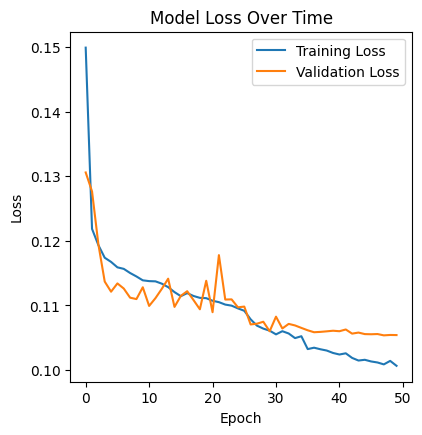

In [35]:
# Training history visualization
plt.figure(figsize=(15, 10))

# Plot 1: Training/Validation Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

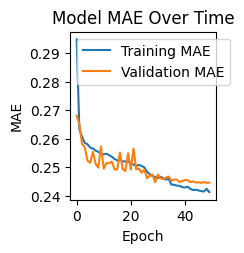

In [36]:
# Plot 2: Training/Validation MAE
plt.subplot(2, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

Text(0.5, 1.0, 'Predicted vs Actual Ratings')

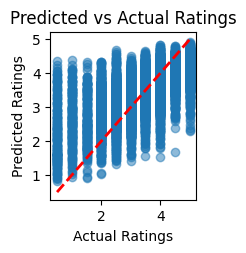

In [37]:
# Plot 3: Prediction vs Actual (Test Set)
plt.subplot(2, 3, 3)
plt.scatter(y_test_true, test_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')

Text(0, 0.5, 'MSE')

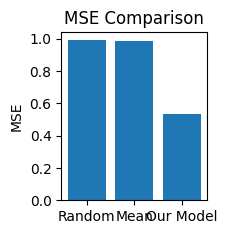

In [38]:
# Plot 4: Model Comparison
plt.subplot(2, 3, 5)
methods = ['Random', 'Mean', 'Our Model']
mse_scores = [random_mse, mean_mse, test_results['MSE']]
plt.bar(methods, mse_scores)
plt.title('MSE Comparison')
plt.ylabel('MSE')

([0, 1, 2],
 [Text(0, 0, 'Config 1'), Text(1, 0, 'Config 2'), Text(2, 0, 'Config 3')])

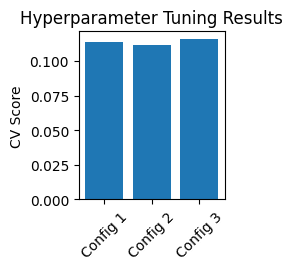

In [39]:
# Plot 5: Hyperparameter Tuning Results
plt.subplot(2, 3, 5)
tuning_scores = [result['cv_score'] for result in tuning_results]
config_names = [f"Config {i+1}" for i in range(len(tuning_results))]
plt.bar(config_names, tuning_scores)
plt.title('Hyperparameter Tuning Results')
plt.ylabel('CV Score')
plt.xticks(rotation=45)

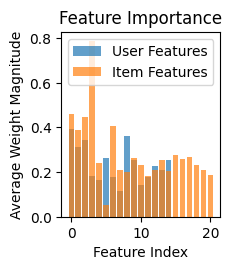

In [40]:
# Plot 6: Feature Importance (User vs Item)
plt.subplot(2, 3, 6)
user_importance = np.mean(np.abs(final_model.get_layer('user_dense_0').get_weights()[0]), axis=1)
item_importance = np.mean(np.abs(final_model.get_layer('item_dense_0').get_weights()[0]), axis=1)

plt.bar(range(len(user_importance)), user_importance, alpha=0.7, label='User Features')
plt.bar(range(len(item_importance)), item_importance, alpha=0.7, label='Item Features')
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Average Weight Magnitude')
plt.legend()

plt.tight_layout()
plt.show()

#FINAL PERFORMANCE SUMMARY

In [41]:
# Create comprehensive performance report
performance_summary = {
    'Model Architecture': {
        'Type': 'Hybrid (Content-Based + Collaborative)',
        'User Hidden Units': best_config['user_hidden_units'],
        'Item Hidden Units': best_config['item_hidden_units'],
        'Output Dimensions': best_config['num_outputs'],
        'Dropout Rate': best_config['dropout_rate'],
        'Activation': best_config['activation']
    },
    'Training Results': train_results,
    'Test Results': test_results,
    'Baseline Comparison': {
        'Random Baseline MSE': random_mse,
        'Mean Baseline MSE': mean_mse,
        'Our Model MSE': test_results['MSE'],
        'Improvement over Random': (random_mse - test_results['MSE']) / random_mse * 100,
        'Improvement over Mean': (mean_mse - test_results['MSE']) / mean_mse * 100
    }
}

print("\n=== MODEL ARCHITECTURE ===")
for key, value in performance_summary['Model Architecture'].items():
    print(f"{key}: {value}")

print("\n=== PERFORMANCE METRICS ===")
print("Training Performance:")
for metric, value in performance_summary['Training Results'].items():
    print(f"  {metric}: {value:.4f}")

print("\nTesting Performance:")
for metric, value in performance_summary['Test Results'].items():
    print(f"  {metric}: {value:.4f}")

print("\n=== BASELINE COMPARISON ===")
for key, value in performance_summary['Baseline Comparison'].items():
    if 'Improvement' in key:
        print(f"{key}: {value:.2f}%")
    else:
        print(f"{key}: {value:.4f}")



=== MODEL ARCHITECTURE ===
Type: Hybrid (Content-Based + Collaborative)
User Hidden Units: [512, 256, 128]
Item Hidden Units: [512, 256, 128]
Output Dimensions: 64
Dropout Rate: 0.3
Activation: relu

=== PERFORMANCE METRICS ===
Training Performance:
  MSE: 0.4970
  MAE: 0.5322
  RMSE: 0.7050
  Precision@5: 1.0000
  Recall@5: 0.0002
  Precision@10: 1.0000
  Recall@10: 0.0004
  NDCG@5: 0.8448
  NDCG@10: 0.8588
  Coverage: 0.9962

Testing Performance:
  MSE: 0.5351
  MAE: 0.5510
  RMSE: 0.7315
  Precision@5: 1.0000
  Recall@5: 0.0009
  Precision@10: 1.0000
  Recall@10: 0.0017
  NDCG@5: 1.0000
  NDCG@10: 0.9313
  Coverage: 0.9990

=== BASELINE COMPARISON ===
Random Baseline MSE: 0.9916
Mean Baseline MSE: 0.9892
Our Model MSE: 0.5351
Improvement over Random: 46.03%
Improvement over Mean: 45.90%
